# Data Analysis


In [18]:
# general_loader.py
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
import json


import requests


def load_jsonl(filepath: str):
    with open(filepath, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f]

def load_jsonl_url(url: str):
    resp = requests.get(url)
    resp.raise_for_status()
    return [json.loads(line) for line in resp.text.splitlines()]

## loading data from drive

In [20]:
subtask = "subtask_1"#don't change
task = "task1"#don't change
langs = ["eng","zho"] #chang the language you want to test
domains = ["restaurant","laptop"] #change what domain you want to test

data = []


for lang in langs:
    for domain in domains:
        train_url = f"https://raw.githubusercontent.com/DimABSA/DimABSA2026/refs/heads/main/task-dataset/track_a/{subtask}/{lang}/{lang}_{domain}_train_alltasks.jsonl"


        try:
            train_raw = load_jsonl_url(train_url)



            data.extend(train_raw)
            print(f"Loaded: {lang}-{domain} ✅")

        except Exception as e:
            print(f"Skipped {lang}-{domain}: {e}")


my_base_url = "https://raw.githubusercontent.com/hassan09070/SE_Aug_data/main"

for lang in langs:
    for domain in domains:
        # Filename pattern from your repo
        filename = f"augmented_{lang}_{domain}_train_alltasks.jsonl"
        aug_url = f"{my_base_url}/{filename}"

        try:
            aug_data = load_jsonl_url(aug_url)
            if aug_data:
                for r in aug_data:
                    r['language'] = lang
                    r['domain'] = domain
                    r['source'] = 'augmented' # Tagging it so we can track it
                data.extend(aug_data)
                print(f"   ✅ Augmented:      {filename} ({len(aug_data)})")
            else:
                print(f"   ❌ Not Found:      {filename}")
        except Exception as e:
            print(f"   ❌ Failed to load augmented data for {lang}-{domain}: {e}")

print(f"\nTotal Training Samples: {len(data)}")


Loaded: eng-restaurant ✅
Loaded: eng-laptop ✅
Loaded: zho-restaurant ✅
Loaded: zho-laptop ✅
   ✅ Augmented:      augmented_eng_restaurant_train_alltasks.jsonl (2780)
   ✅ Augmented:      augmented_eng_laptop_train_alltasks.jsonl (4222)
   ❌ Failed to load augmented data for zho-restaurant: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/hassan09070/SE_Aug_data/main/augmented_zho_restaurant_train_alltasks.jsonl
   ❌ Failed to load augmented data for zho-laptop: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/hassan09070/SE_Aug_data/main/augmented_zho_laptop_train_alltasks.jsonl

Total Training Samples: 22902


## Flattening dataset into quadruples

In [21]:
def load_general_dataset(data):
    """
    Load SemEval dataset in general format (one row per quadruplet).

    Returns: DataFrame with columns:
    ID, Text, Aspect, Category, Opinion, VA, V, A
    """


    records = []
    for row in data:
        for quad in row["Quadruplet"]:
            V, A = map(float, quad["VA"].split("#"))
            records.append({
                "ID": row["ID"],
                "Text": row["Text"],
                "Aspect": quad["Aspect"],
                "Category": quad["Category"],
                "Opinion": quad["Opinion"],
                "V": V,
                "A": A
            })

    return pd.DataFrame(records)

In [22]:
df = load_general_dataset(data)
df.head()

,ID,Text,Aspect,Category,Opinion,V,A
0,rest16_quad_dev_1,ca n ' t wait wait for my next visit .,NULL,RESTAURANT#GENERAL,NULL,6.75,6.38
1,rest16_quad_dev_2,"their sake list was extensive , but we were lo...",sake list,DRINKS#STYLE_OPTIONS,extensive,7.83,8.00
2,rest16_quad_dev_2,"their sake list was extensive , but we were lo...",NULL,SERVICE#GENERAL,NULL,5.00,5.00
3,rest16_quad_dev_3,the spicy tuna roll was unusually good and the...,spicy tuna roll,FOOD#QUALITY,unusually good,7.50,7.62
4,rest16_quad_dev_3,the spicy tuna roll was unusually good and the...,rock shrimp tempura,FOOD#QUALITY,awesome,8.25,8.38


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31459 entries, 0 to 31458
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        31459 non-null  object 
 1   Text      31459 non-null  object 
 2   Aspect    31459 non-null  object 
 3   Category  31459 non-null  object 
 4   Opinion   31459 non-null  object 
 5   V         31459 non-null  float64
 6   A         31459 non-null  float64
dtypes: float64(2), object(5)
memory usage: 1.7+ MB


In [24]:
print("Sentence-level entries:", len(data))
print("Quadruplet-level entries:", len(df))


Sentence-level entries: 22902
Quadruplet-level entries: 31459


In [25]:
print("Number of columns:", len(df.columns))
print("Columns:", df.columns.tolist())


Number of columns: 7
Columns: ['ID', 'Text', 'Aspect', 'Category', 'Opinion', 'V', 'A']


In [26]:
print("Unique Categories:", df["Category"].nunique())
print("Unique Aspects:", df["Aspect"].nunique())
print("Unique Opinions:", df["Opinion"].nunique())


Unique Categories: 155
Unique Aspects: 7827
Unique Opinions: 9657


In [27]:
category_counts = df["Category"].value_counts()
category_ratio = category_counts / category_counts.sum()

print("Category counts:\n", category_counts)
print("\nCategory ratio:\n", category_ratio)


Category counts:
 Category
FOOD#QUALITY                    8643
LAPTOP#GENERAL                  3129
LAPTOP#DESIGN_FEATURES          2192
LAPTOP#OPERATION_PERFORMANCE    1635
SERVICE#GENERAL                 1425
                                ... 
FANS_COOLING#PRICE                 1
MOUSE#QUALITY                      1
FANS_COOLING#USABILITY             1
MOTHERBOARD#PRICE                  1
BATTERY#PORTABILITY                1
Name: count, Length: 155, dtype: int64

Category ratio:
 Category
FOOD#QUALITY                    0.274739
LAPTOP#GENERAL                  0.099463
LAPTOP#DESIGN_FEATURES          0.069678
LAPTOP#OPERATION_PERFORMANCE    0.051972
SERVICE#GENERAL                 0.045297
                                  ...   
FANS_COOLING#PRICE              0.000032
MOUSE#QUALITY                   0.000032
FANS_COOLING#USABILITY          0.000032
MOTHERBOARD#PRICE               0.000032
BATTERY#PORTABILITY             0.000032
Name: count, Length: 155, dtype: float64



Quadruplets per sentence:
 count    20695.000000
mean         1.520126
std          0.877248
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         26.000000
Name: Aspect, dtype: float64


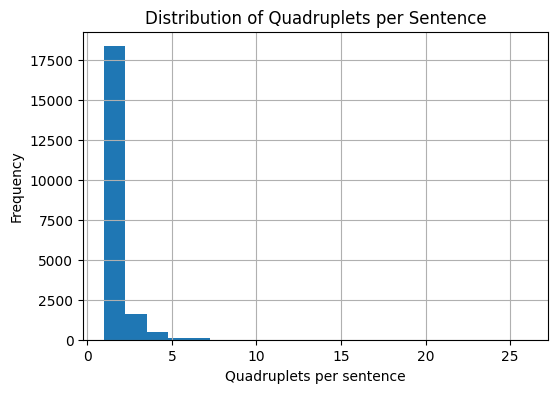

In [28]:
quads_per_sentence = df.groupby("ID")['Aspect'].count()
print("\nQuadruplets per sentence:\n", quads_per_sentence.describe())

plt.figure(figsize=(6,4))
quads_per_sentence.hist(bins=20)
plt.title("Distribution of Quadruplets per Sentence")
plt.xlabel("Quadruplets per sentence")
plt.ylabel("Frequency")
plt.show()

## Data Integrity check

In [29]:
# some aspects and opinions aren't in the sentence therefore considered implicit and a string "NULL"
# These don't indicate annotation error but rather coresspond to implicit aspects/opinions

null_aspects = (df["Aspect"] == "NULL").sum()
null_opinions = (df["Opinion"] == "NULL").sum()

print("Implicit Aspects (string 'NULL'):", null_aspects)
print("Implicit Opinions (string 'NULL'):", null_opinions)

print(f"{null_aspects/len(df)*100:.2f}% aspects are implicit")
print(f"{null_opinions/len(df)*100:.2f}% opinions are implicit")



Implicit Aspects (string 'NULL'): 3851
Implicit Opinions (string 'NULL'): 2321
12.24% aspects are implicit
7.38% opinions are implicit


In [30]:
positive = (df["V"] > 5).sum()
negative = (df["V"] < 5).sum()
neutral  = (df["V"] == 5).sum()

print("Positive samples:", positive)
print("Negative samples:", negative)
print("Neutral samples:", neutral)


Positive samples: 22661
Negative samples: 7617
Neutral samples: 1181


## Distribution for Valence-Arousal

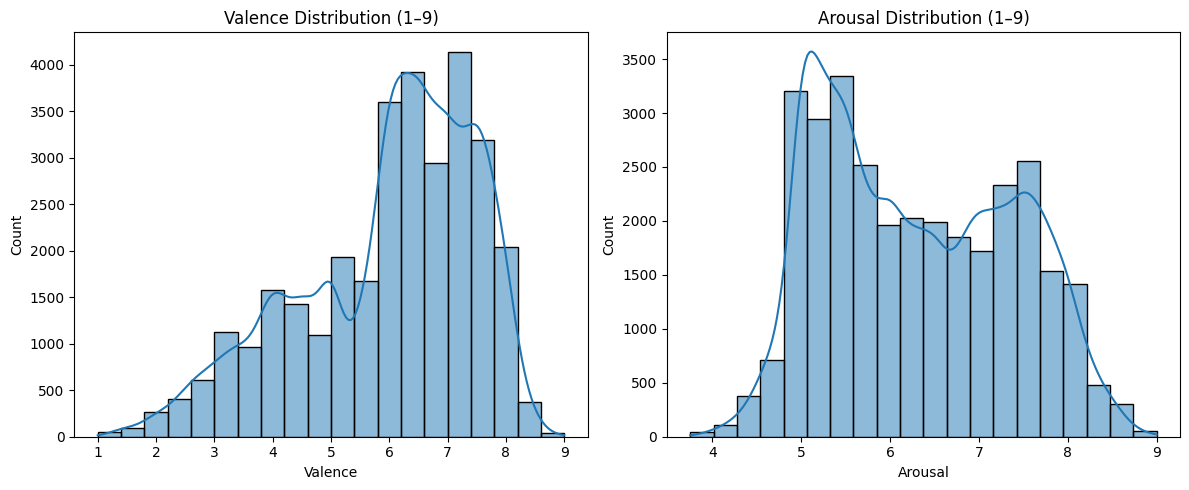

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df["V"], bins=20, kde=True, ax=axes[0])
axes[0].set_title("Valence Distribution (1–9)")
axes[0].set_xlabel("Valence")

sns.histplot(df["A"], bins=20, kde=True, ax=axes[1])
axes[1].set_title("Arousal Distribution (1–9)")
axes[1].set_xlabel("Arousal")

plt.tight_layout()
plt.show()

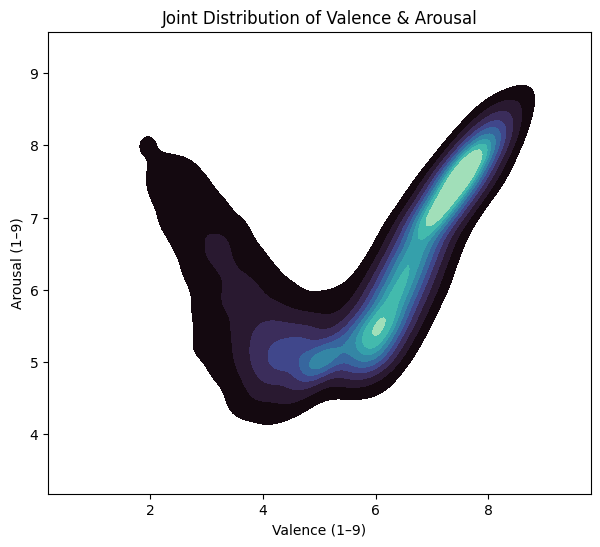

In [32]:
plt.figure(figsize=(7, 6))
sns.kdeplot(x=df["V"], y=df["A"], fill=True, cmap="mako", thresh=0.05)
plt.title("Joint Distribution of Valence & Arousal")
plt.xlabel("Valence (1–9)")
plt.ylabel("Arousal (1–9)")
plt.show()


## Data Analysis for valence-arousal scores

In [33]:
print("Valence stats:\n", df["V"].describe())
print("Arousal stats:\n", df["A"].describe())

Valence stats:
 count    31459.000000
mean         5.965279
std          1.525509
min          1.000000
25%          5.000000
50%          6.250000
75%          7.170000
max          9.000000
Name: V, dtype: float64
Arousal stats:
 count    31459.000000
mean         6.292486
std          1.071826
min          3.750000
25%          5.330000
50%          6.170000
75%          7.250000
max          9.000000
Name: A, dtype: float64



Correlation matrix:
           V         A
V  1.000000  0.534496
A  0.534496  1.000000


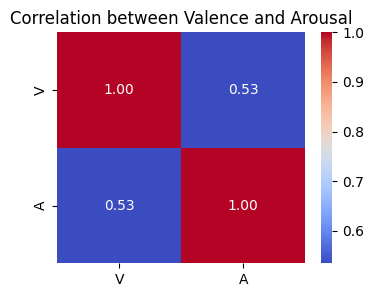

In [34]:
corr = df[['V','A']].corr()
print("\nCorrelation matrix:\n", corr)

plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Valence and Arousal")
plt.show()

In [35]:
extremes_valence = df[(df["V"] <= 2) | (df["V"] >= 8)]
extremes_arousal = df[(df["A"] <= 2) | (df["A"] >= 8)]

print(f"Extreme Valence samples: {len(extremes_valence)} / {len(df)}")
print(f"Extreme Arousal samples: {len(extremes_arousal)} / {len(df)}")


Extreme Valence samples: 1962 / 31459
Extreme Arousal samples: 2239 / 31459


Valence Bin Counts:
 ValenceBin
High      17699
Medium    12059
Low        1701
Name: count, dtype: int64
Arousal Bin Counts:
 ArousalBin
High      16326
Medium    15133
Low           0
Name: count, dtype: int64


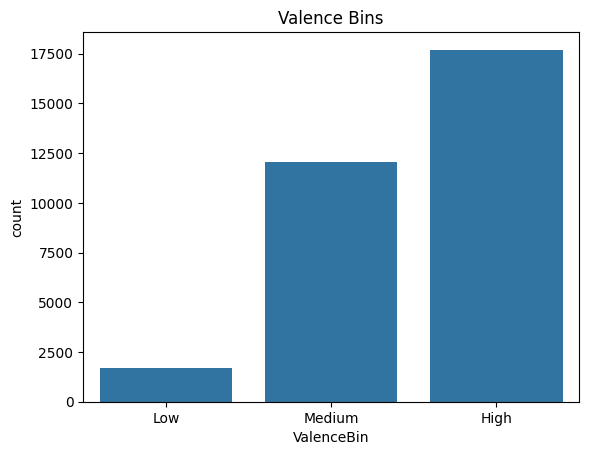

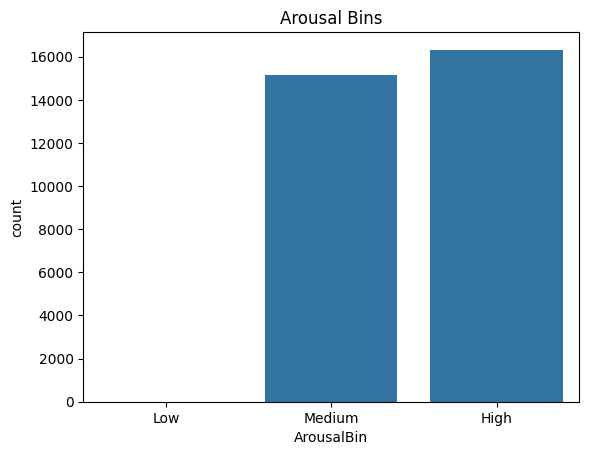

In [36]:
bins = [1, 3, 6, 9]  # example: low (1–3), medium (4–6), high (7–9)
labels = ["Low", "Medium", "High"]

df["ValenceBin"] = pd.cut(df["V"], bins=bins, labels=labels, include_lowest=True)
df["ArousalBin"] = pd.cut(df["A"], bins=bins, labels=labels, include_lowest=True)

print("Valence Bin Counts:\n", df["ValenceBin"].value_counts())
print("Arousal Bin Counts:\n", df["ArousalBin"].value_counts())

sns.countplot(x="ValenceBin", data=df)
plt.title("Valence Bins")
plt.show()

sns.countplot(x="ArousalBin", data=df)
plt.title("Arousal Bins")
plt.show()



Quadrant distribution:
 Quadrant
High Valence, High Arousal    23344
Low Valence, High Arousal      6268
Low Valence, Low Arousal       1349
High Valence, Low Arousal       498
Name: count, dtype: int64


/tmp/ipython-input-3581525468.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=quad_counts.index, y=quad_counts.values, palette="magma")


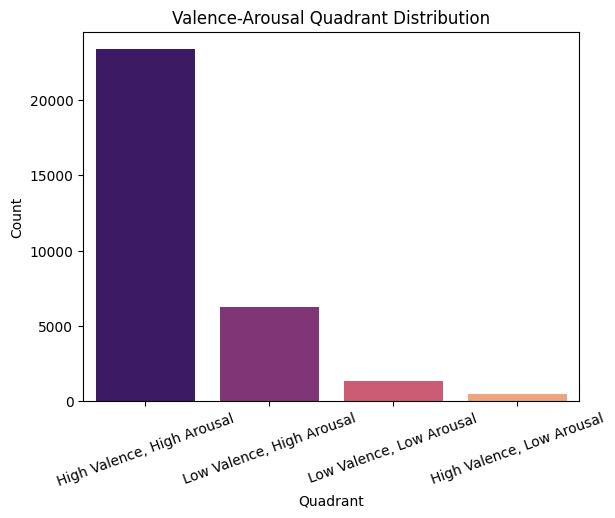

In [37]:
def quadrant(v, a):
    if v >= 5 and a >= 5: return "High Valence, High Arousal"
    if v < 5 and a >= 5: return "Low Valence, High Arousal"
    if v < 5 and a < 5: return "Low Valence, Low Arousal"
    return "High Valence, Low Arousal"

df['Quadrant'] = df.apply(lambda row: quadrant(row['V'], row['A']), axis=1)
quad_counts = df['Quadrant'].value_counts()
print("\nQuadrant distribution:\n", quad_counts)

sns.barplot(x=quad_counts.index, y=quad_counts.values, palette="magma")
plt.title("Valence-Arousal Quadrant Distribution")
plt.ylabel("Count")
plt.xticks(rotation=20)
plt.show()